# Kaggle Heart Attack Prediction dataset

This data set has data from patients and looks to classify the patient as having low probability for having a heart attack (0) or having a high probability for having a heart attack (1).

The link to the data set is [Kaggle](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)

## Loading packages for analyzing and modeling data

In [24]:
# Packages to hold and pre-process data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling packages
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import sklearn
from sklearn import svm

import itertools

# Due to having and exploratory component when visualizing plenty of warnings come up, so ignore them for this notebook
import warnings
warnings.filterwarnings("ignore")


## Data Analysis and Preprocessing

In [25]:
#Load data into DataFrames
heart_data = pd.read_csv('heart.csv')
o2_data = pd.read_csv('o2Saturation.csv')

In [26]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [27]:
o2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   98.6    3585 non-null   float64
dtypes: float64(1)
memory usage: 28.1 KB


From the first overview of the two files in the dataset, it can be seen that the hear.csv file containes 303 observations, while the o2Saturation.csv file containes 3585 observations. Given the difference in observations, and that there is no additional information the analysis for predicting values will be performed only with the heart.csv features. Since there are no columns with missing data there will be no need to perform any data imputation.

In [28]:
heart_data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


From the column names and the information on the first 5 observations we can confirm the data set contains both continuos variables and categorical variables. For continuos variables the statistical properties could be of interest, for categorial data the count of sub-types can give some insights to the data. To validate which names of columns are categorial print out unique values, if the set is small, it is an indication of some ordinal or categorical data. 

In [29]:
heart_data.nunique()

age          41
sex           2
cp            4
trtbps       49
chol        152
fbs           2
restecg       3
thalachh     91
exng          2
oldpeak      40
slp           3
caa           5
thall         4
output        2
dtype: int64

In [30]:
# Create dictionary using column names and unique count, and from that pass it to a DataFrame
dic_unique = dict(zip([i for i in heart_data.columns],[len(heart_data[i].unique()) for i in heart_data.columns]))
print(dic_unique)

{'age': 41, 'sex': 2, 'cp': 4, 'trtbps': 49, 'chol': 152, 'fbs': 2, 'restecg': 3, 'thalachh': 91, 'exng': 2, 'oldpeak': 40, 'slp': 3, 'caa': 5, 'thall': 4, 'output': 2}


From the low count in unique entries the continuos, categorial, and target/predicted columns will be

In [31]:
cont_colms=["age","trtbps","chol","thalachh","oldpeak"]
categ_colms=["sex","cp","fbs","restecg","exng","slp","caa","thall"]
output_colms=["output"]

In [32]:
print("Number of continuous variables is {}".format(len(cont_colms)))
print("Number of categorial variables is {}".format(len(categ_colms)))

Number of continuous variables is 5
Number of categorial variables is 8


## Continuos Variables

In [33]:
# Statistics for continuous variables
heart_data[cont_colms].describe()

,age,trtbps,chol,thalachh,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'trtbps'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'thalachh'}>],
       [<AxesSubplot:title={'center':'oldpeak'}>, <AxesSubplot:>]],
      dtype=object)

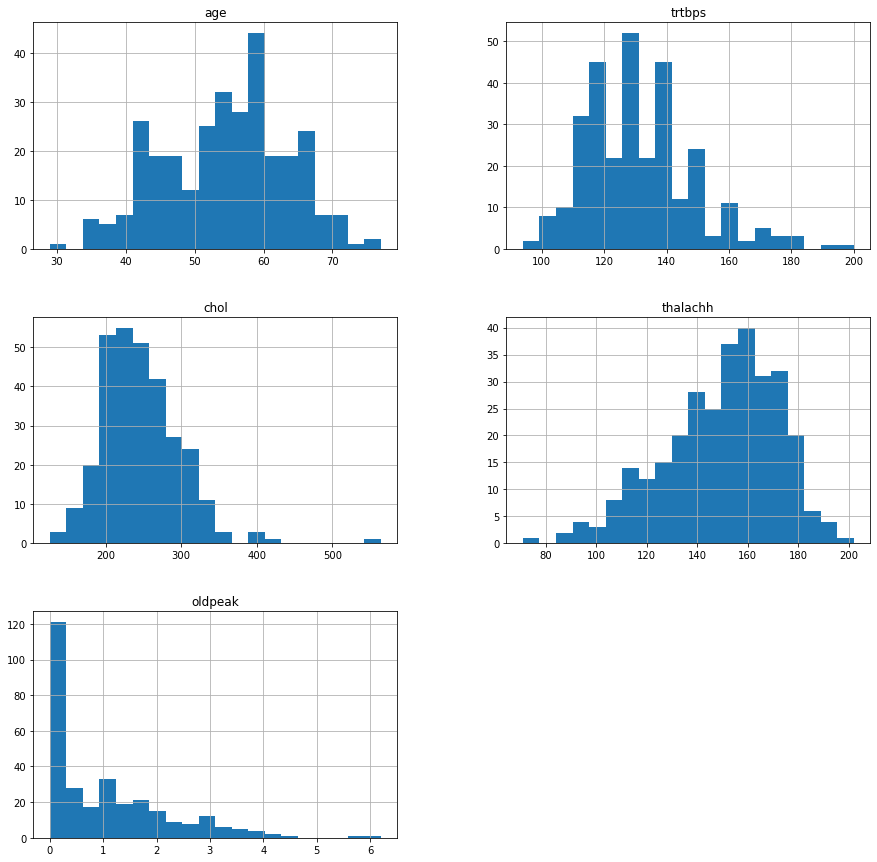

In [34]:
#Show distribution of continuous variables
heart_data[cont_colms].hist(figsize=(15,15),bins=20)

From the histogram plots it can be seen that the continuous variables have some outliers, as well as some underlying distribution of values. This suggests using box plots to better understand the data. Seaborn has boxenplots and violin plots, since we want to visualize outliers, we will use the boxenplot. To understand any effect with respect to the output the histogram or distribution plots will be separated according to the output. 

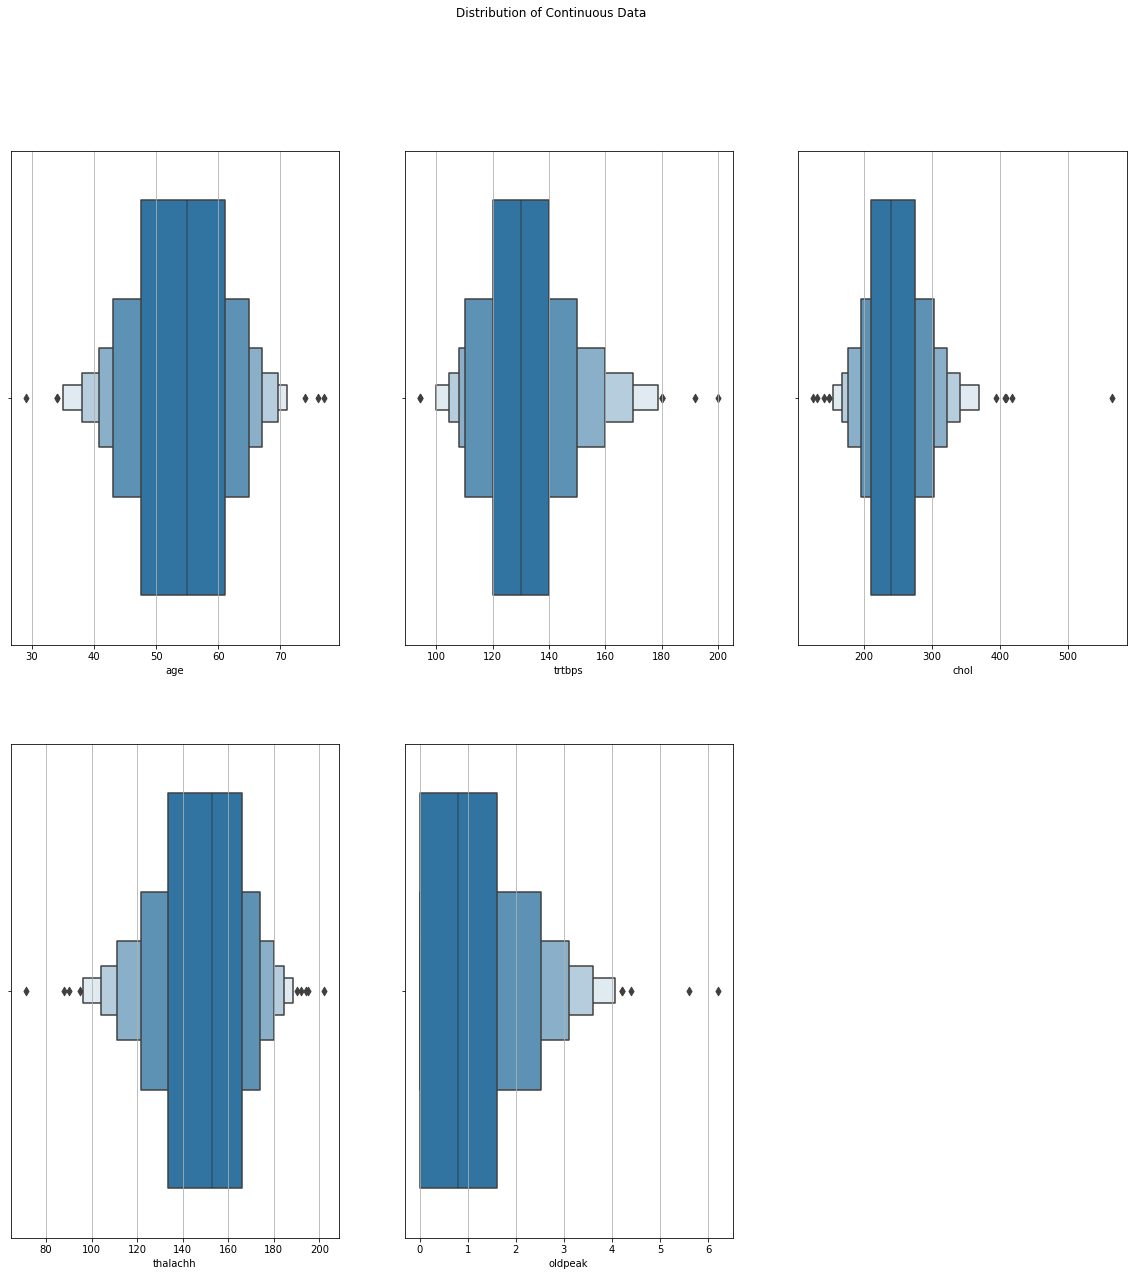

In [35]:
# Plot categorial count plots on 2 x 3 subplot grid
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(20,20))
fig.suptitle("Distribution of Continuous Data")
for i in range(2):
    for j in range(3):
        if i==1 and j ==2:
            continue
        else:
            sns.boxenplot(data=heart_data,x=cont_colms[3*i+j],ax=axs[i,j])
            axs[i,j].xaxis.grid(True)
fig.delaxes(axs[1,2])

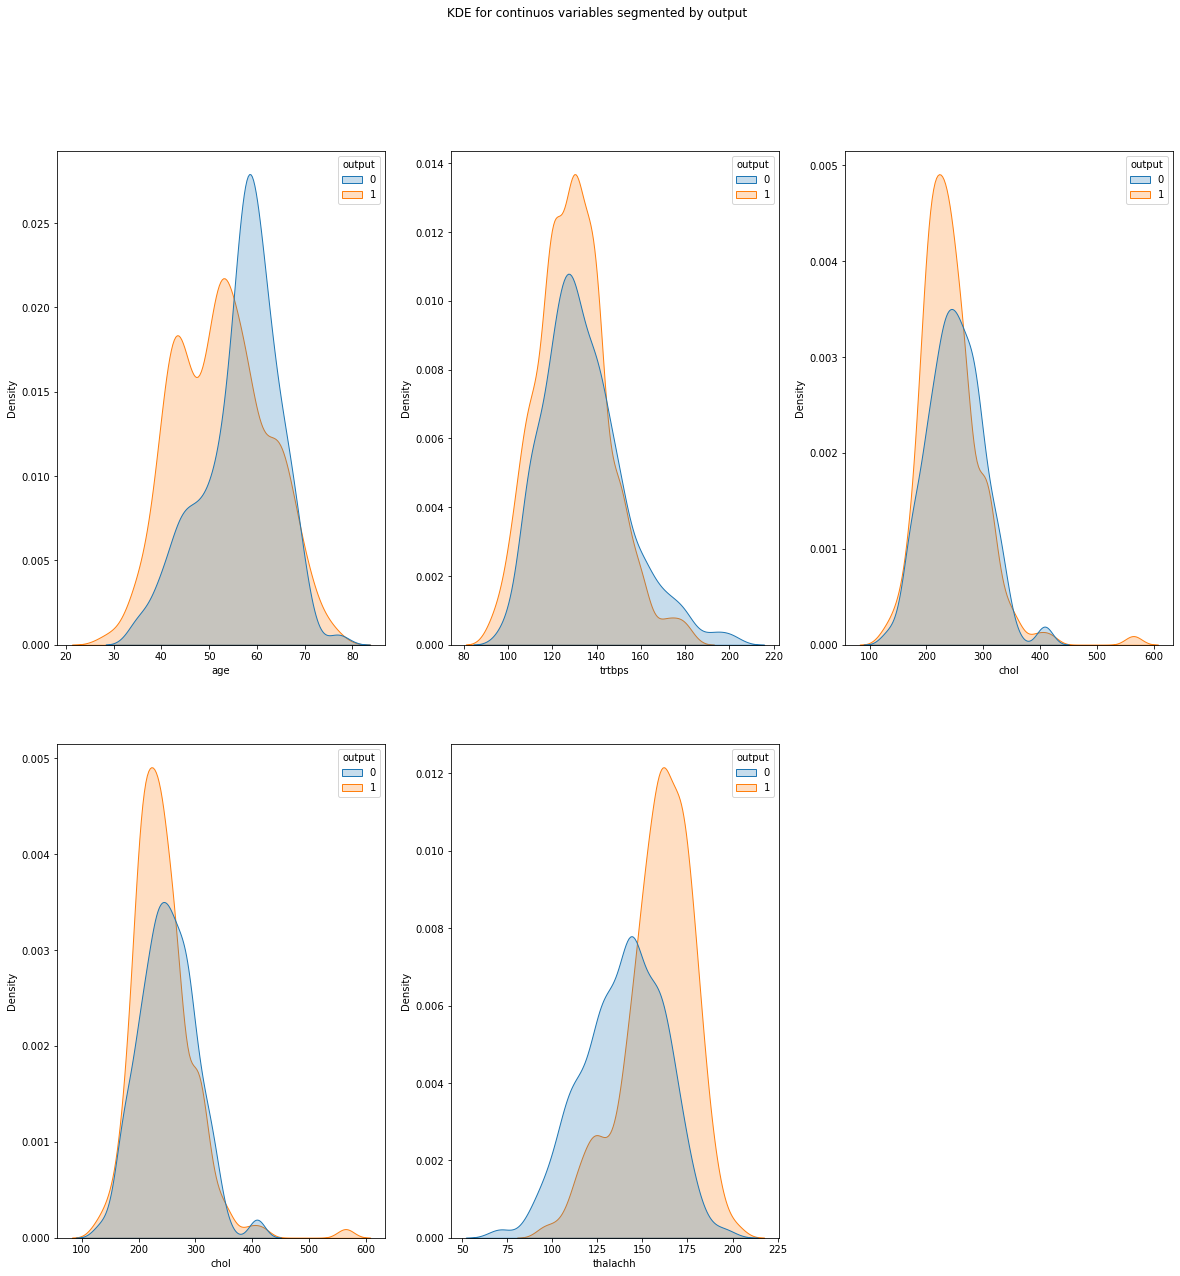

In [36]:
# Plot categorial count plots on 2 x 3 subplot grid
# Here displot and kdeplot give similar output, however the first is a figure level function and the second is an axis level function, 
# so the latter will be used to loop with the same construt as before
# Bandiwth adjustment parameter was chosen to smooth out all underlying distributions
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(20,20))
fig.suptitle("KDE for continuos variables segmented by output")
for i in range(2):
    for j in range(3):
        if i==1 and j ==2:
            continue
        else:
            sns.kdeplot(data=heart_data,x=cont_colms[2*i+j],ax=axs[i,j],hue="output",bw_adjust=0.75,fill=True)            
fig.delaxes(axs[1,2])        

From the plots it seems to indicate that for **age** and **thalachh** variables there is a difference in the mean and shape of the distribution. This could be a sampling issue, further investigations are needed to test differnce between the means. 

To avoid overfitting use Pearson correlation coefficient to understand relation between continuous variables

<AxesSubplot:>

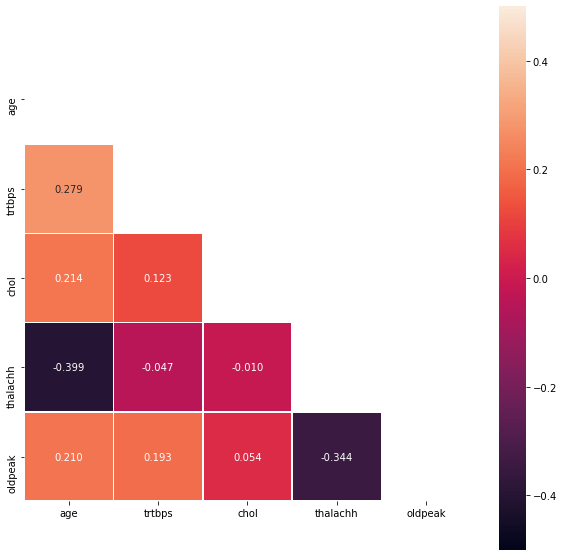

In [37]:
corr = heart_data[cont_colms].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(10,10))
sns.heatmap(corr,mask=mask,square=True,linewidths=.5,annot=True,fmt=".3f",vmin=-.5,vmax=.5)

Witht the Pearson correlation coefficient it seems there is a very strong negative correlation between **thalachh** and **age**, as well as between **thalachh** and **oldpeak**. However, since the number of observations is small we will keep the features and adjust the models accordingly. 

## Categorical Variables

From the count of unique entries it can be seen that the categorical data has between 2 and 5 unique entries depending on the column, so it would be interesting to do the count per each sub-type and visualize it

In [38]:
# Create dictionary with count of subtypes for each categorical columns
unique_vals=[]
categ_counts=[]
for i, col_name in enumerate(heart_data[categ_colms]):
    val_cat = list(heart_data[col_name].unique())
    sub_count = [len(heart_data[heart_data[col_name]==cat_count]) for j, cat_count in enumerate(heart_data[col_name].unique())]
    unique_vals.append(val_cat)
    categ_counts.append(sub_count)
print(unique_vals)
print(categ_counts)

[[1, 0], [3, 2, 1, 0], [1, 0], [0, 1, 2], [0, 1], [0, 2, 1], [0, 2, 1, 3, 4], [1, 2, 3, 0]]
[[207, 96], [23, 87, 50, 143], [45, 258], [147, 152, 4], [204, 99], [21, 142, 140], [175, 38, 65, 20, 5], [18, 166, 117, 2]]


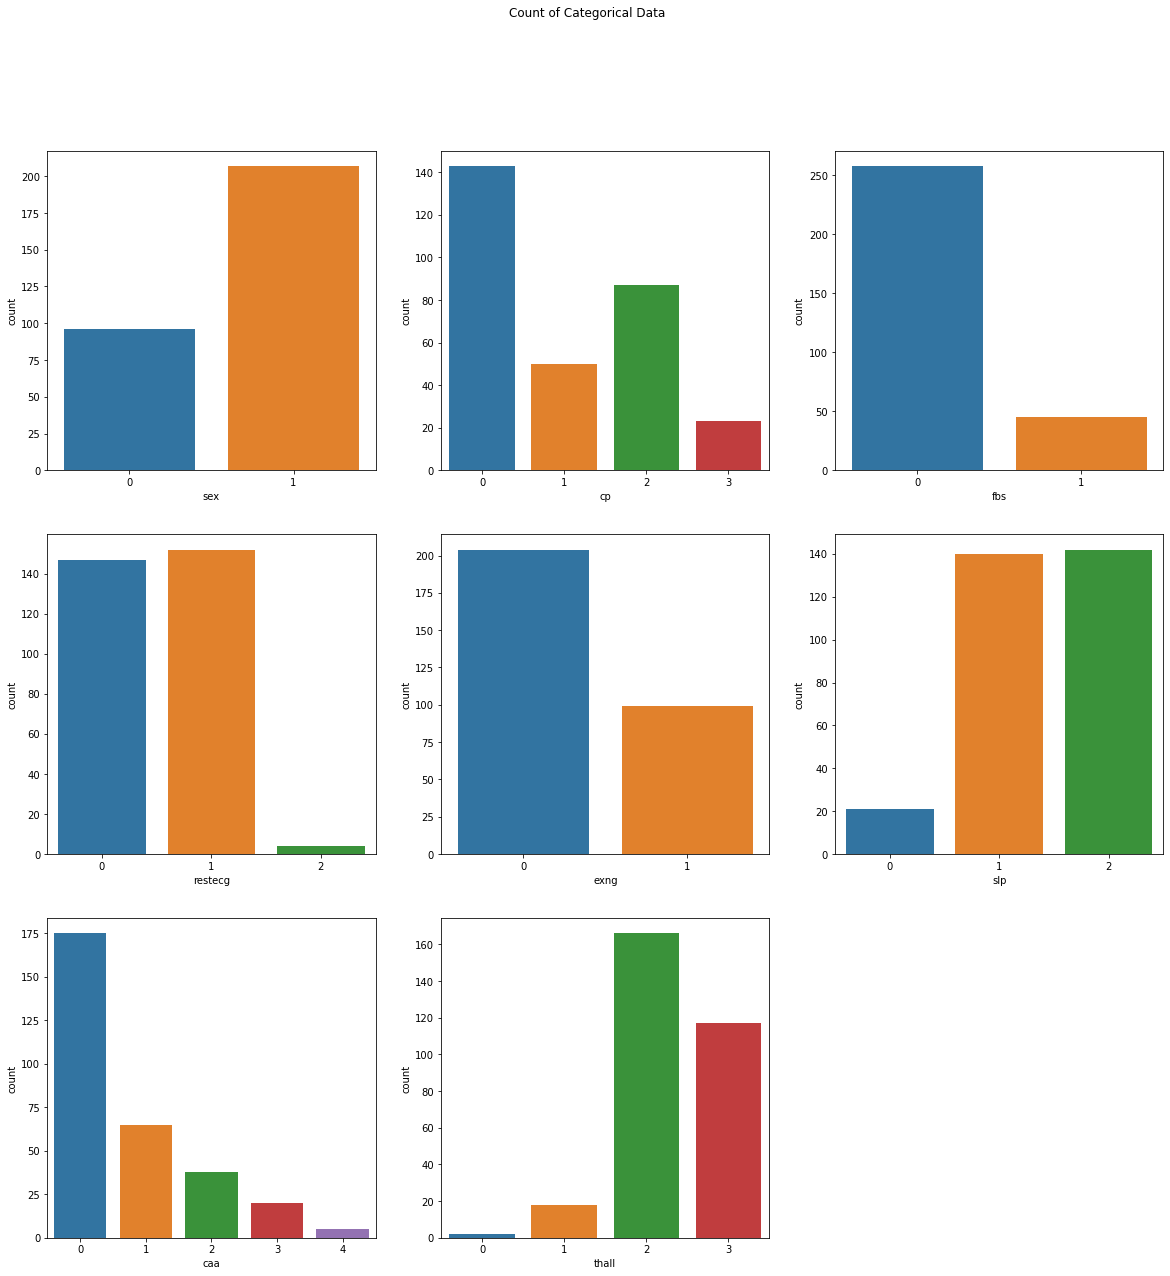

In [39]:
# Plot categorial count plots on 3 x 3 subplot grid
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(20,20))
fig.suptitle("Count of Categorical Data")
for i in range(3):
    for j in range(3):
        if i==2 and j ==2:
            continue
        else:
            sns.countplot(data=heart_data,x=categ_colms[3*i+j],ax=axs[i,j])
fig.delaxes(axs[2,2])

## Creating models to understand data

Since the goal is to perform binary classification based on the available features, this suggests using the algorithms:
 - SVM
 - Neural Networks

The data that will be used will be scaled to train the models. 

To compare the models, the data will be split into training and testing data, and the metric to compare them will be the accuracy of the model on the validation set. 


In [40]:
#Separate features and objective
X = heart_data.drop(["output"],axis=1).copy()
Y = heart_data["output"].copy()

# Scaling of continuous variables using Robust Scales as the samples have outliers
scaler = sklearn.preprocessing.RobustScaler()
X[cont_colms]=scaler.fit_transform(X[cont_colms])
X.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,0.592593,1,3,0.75,-0.110236,1,0,-0.092308,0,0.9375,0,0,1
1,-1.333333,1,2,0.00,0.157480,0,1,1.046154,0,1.6875,0,0,2
2,-1.037037,0,1,0.00,-0.566929,0,0,0.584615,0,0.3750,2,0,2
3,0.074074,1,1,-0.50,-0.062992,0,1,0.769231,0,0.0000,2,0,2
4,0.148148,0,0,-0.50,1.795276,0,1,0.307692,1,-0.1250,2,0,2


In [41]:
# Training and testing split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,shuffle=True)

## SVM

The SVM packge of Scikitlearn implements vector classification with the module SVC, which allos for regularization and use of different kernels. The hyper parameters of the models will be adjusted to maximize the accuracy on the validation set. 

In [42]:
# Implement vector classification
clf = svm.SVC(C=10,kernel="poly")
clf.fit(x_train,y_train)
accuracy_train = clf.score(x_train,y_train)
y_pred = clf.predict(x_test)
accuracy_test = sklearn.metrics.accuracy_score(y_test,y_pred)
results = dict({"Training Accuracy":[accuracy_train],"Testing Accuracy":[accuracy_test]})
result=pd.DataFrame.from_dict(results)
result.head()

,Training Accuracy,Testing Accuracy
0,0.958678,0.852459


In [43]:
# Perform hyperparameter search, the search range for exponential range started -2 to 3, and iteratively shortened the range -1 to 1
c_param = np.logspace(-1,1,30)
gamma_param = np.logspace(-1,1,30)
training_accuracy=[]
testing_accuracy=[]
results = pd.DataFrame({"Regularization":[],"Gamma":[],"Training Accuracy":[],"Testing Accuracy":[]})
for i, c in enumerate(c_param):
    for j,gamma in enumerate(gamma_param):
        clf = svm.SVC(C=c,gamma=gamma)
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        training_accuracy.append(clf.score(x_train,y_train))
        testing_accuracy.append(sklearn.metrics.accuracy_score(y_test,y_pred))
        
# Create cartesian product of parameters for DataFrame
c_list = []
g_list = []
for elem in itertools.product(c_param,gamma_param):
    c_list.append(elem[0])
    g_list.append(elem[1])

results = pd.DataFrame({"Regularization":c_list,"Gamma":g_list,"Training Accuracy":training_accuracy,"Testing Accuracy":testing_accuracy})

In [44]:
mloc = results["Testing Accuracy"].argmax()
results.iloc[mloc]

Regularization       2.043360
Gamma                0.100000
Training Accuracy    0.921488
Testing Accuracy     0.885246
Name: 570, dtype: float64

With SVM the max accuracy on the validation set is **0.868852**

## Neural Network

For testing purposes we will define a neural netowkr with 2 hidden layers whose dimensions are to be defined, and the output is two components of a vector which will be transformed using a softmax function and from that define the classification

In [45]:
class NetClassifier(nn.Module):
    def __init__(self,hidden1,hidden2):
        super(NetClassifier,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(13,hidden1),
            nn.ReLU(),
            nn.Linear(hidden1,hidden2),
            nn.ReLU(),
            nn.Linear(hidden2,2),
        )
    def forward(self,x):
        x = self.model(x)
        return x

In [46]:
# Create an instance of the class
net = NetClassifier(20,20)
print(net)

NetClassifier(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)


In [47]:
# Define training parameters
EPOCHS = 50
BATCH_SIZE=32
LEARNING_RATE = 0.01

# Define optimizer and loss function
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

In [48]:
# Define variables as tensors to train the model
x_train_t = torch.tensor(x_train.values, dtype=torch.float)
x_test_t = torch.tensor(x_test.values, dtype=torch.float)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t = torch.tensor(y_test.values, dtype=torch.long)

In [49]:
# Create DataSet and DataLoaders to train the neural network
train_data_set = TensorDataset(x_train_t,y_train_t) 
test_data_set = TensorDataset(x_test_t,y_test_t)

train_dataloader = DataLoader(train_data_set,batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data_set,batch_size = BATCH_SIZE)

In [50]:
# Save losses for each bath for all epochs for plotting learning curve
losses=[]
for epoch in range(EPOCHS):
    epoch_loss=0
    epoch_acc=0
    for xb,yb in train_dataloader:
        # Zero gradients for training
        optimizer.zero_grad()
        # Use current model parameters to predict output
        y_pred = net(xb)
        #y_pred = torch.flatten(y_pred)
        # Turn probabilities into prediction 
        #pred = torch.round(torch.sigmoid(torch.flatten(y_pred)))
        # Calculate loss, use float type to calculate loss
        loss = loss_function(y_pred,yb)
        losses.append(loss.item())
        # Backpropagate
        loss.backward()
        # Step in the optimizer
        optimizer.step()
        epoch_loss+=loss.item()
        epoch_acc+=(yb == torch.argmax(y_pred,dim=1)).float().mean()
# Print epoch loss
    if epoch%10==0:
        print("Epoch {:>02d} | Loss {:.5f} | Acc {:.3f}".format(epoch,epoch_loss/len(train_dataloader),epoch_acc/len(train_dataloader)))

Epoch 00 | Loss 0.66926 | Acc 0.556
Epoch 10 | Loss 0.26600 | Acc 0.900
Epoch 20 | Loss 0.14664 | Acc 0.938
Epoch 30 | Loss 0.04149 | Acc 0.992
Epoch 40 | Loss 0.13981 | Acc 0.953


In [51]:
# With trained nn predict the values for validation set and test accuracy
y_val = net(x_test_t)
y_val = torch.argmax(y_val,dim=1)
accuracy = (y_val == y_test_t).float().mean()
print("Classification accuracy for nn is {}".format(accuracy))

Classification accuracy for nn is 0.7704917788505554


Text(0.5, 0, 'Batch iteration')

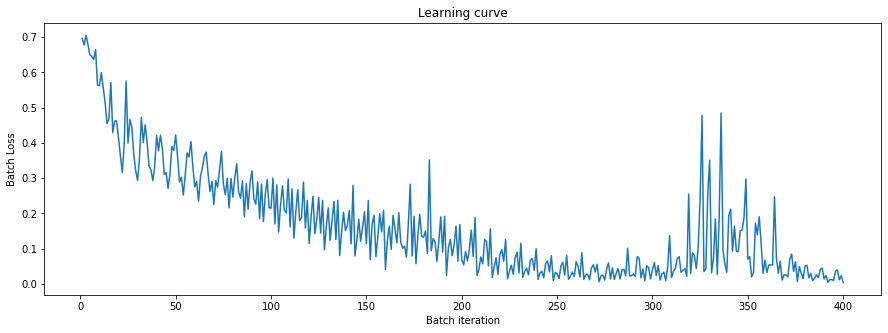

In [52]:
# Plot learning curve
plt.figure(figsize=(15,5))
sns.lineplot(np.arange(1,len(losses)+1),losses)
plt.title("Learning curve")
plt.ylabel("Batch Loss")
plt.xlabel("Batch iteration")

Wrap the implemented class to perform search for hyper parameters that leads to best accuracy on validation set

In [110]:
# Define range of parameters to test
hid1=np.arange(15,51,1)
hid2=np.arange(15,51,1)
# Create empty tuple to store results for training and testing values
training_acc=[]
training_loss=[]
testing_acc=[]

# Define training parameters
EPOCHS = 80
BATCH_SIZE=32
LEARNING_RATE = 0.01

# Search parameter space
for i, hidden1 in enumerate(hid1):
    for j, hidden2 in enumerate(hid2):
        # Define instance of class to test
        netb = NetClassifier(hidden1,hidden2)
        # Define optimizer and loss function
        optimizer = optim.Adam(netb.parameters(),lr=LEARNING_RATE)
        loss_function = nn.CrossEntropyLoss()
        # Perform training
        for epoch in range(EPOCHS):
            epoch_loss=0
            epoch_acc=0
            for xb,yb in train_dataloader:
            # Zero gradients for training
                optimizer.zero_grad()
            # Use current model parameters to predict output
                y_pred = net(xb)
            # Calculate loss, use float type to calculate loss
                loss = loss_function(y_pred,yb)
                losses.append(loss.item())
                # Backpropagate
                loss.backward()
                # Step in the optimizer
                optimizer.step()
                epoch_loss+=loss.item()
                epoch_acc+=(yb == torch.argmax(y_pred,dim=1)).float().mean()
        # Store accuracy on training set at end of training
        training_acc.append((torch.argmax(netb(x_train_t),dim=1)==y_train_t).float().mean().numpy())
        # Store loss on training set at end of training
        training_loss.append(loss_function(netb(x_train_t),y_train_t).item())
        # Store accuracy on testing set at end of training
        testing_acc.append((torch.argmax(netb(x_test_t),dim=1)==y_test_t).float().mean().numpy())

# Create cartesian product of parameters for DataFrame
h1_list = []
h2_list = []
for elem in itertools.product(hid1,hid2):
    h1_list.append(elem[0])
    h2_list.append(elem[1])
        
# Put results in a Data Frame
results = pd.DataFrame({"Neurons H1":h1_list,"Neurons H2":h2_list,"Training Loss":training_loss,
                        "Training Accuracy":training_acc,"Testing Accuracy":testing_acc})

In [111]:
results.head()

,Neurons H1,Neurons H2,Training Loss,Training Accuracy,Testing Accuracy
0,15,15,0.720468,0.42561984,0.5081967
1,15,16,0.703453,0.446281,0.4918033
2,15,17,0.691365,0.5495868,0.4918033
3,15,18,0.689859,0.57438016,0.47540984
4,15,19,0.682574,0.59504133,0.55737704


In [112]:
results = results.astype("float")
mloc = results["Testing Accuracy"].argmax()
results.iloc[mloc]

Neurons H1           17.000000
Neurons H2           36.000000
Training Loss         0.649433
Training Accuracy     0.797521
Testing Accuracy      0.786885
Name: 93, dtype: float64

With the parameter search for the neural network architecture that predicts best on the validation set, it can be seen that the parameters **H1=17**, **H2=36** give an accuracy for the training and testing set of about **79%**. That is it performs about as well on seen data as on unseen data. 

## Logistic Regression

In [99]:
#Define LogisticRegression class by implementing a linear model with a sigmoid activation layer, use BCELoss for loss function
class LogisticRegression(nn.Module):
    def __init__(self,n_input_features):
        super(LogisticRegression,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input_features,1),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=self.model(x)
        return x

In [84]:
n_features = X.shape[1]
lr = LogisticRegression(n_features)
print(lr)

LogisticRegression(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [100]:
# Define learning parameters
learning_rate=0.001
EPOCHS_LR=100
BATCH_SIZE=32
#Define optimizer
lr_optimizer = optim.Adam(lr.parameters(),lr=learning_rate)
#Define loss function
lr_loss = nn.BCELoss()

In [85]:
# Define variables as tensors to train the model, BCELoss requires target of type float
x_train_t = torch.tensor(x_train.values, dtype=torch.float)
x_test_t = torch.tensor(x_test.values, dtype=torch.float)
y_train_t = torch.tensor(y_train.values, dtype=torch.float)
y_test_t = torch.tensor(y_test.values, dtype=torch.float)

In [86]:
# Create DataSet and DataLoaders to train the neural network
train_data_set = TensorDataset(x_train_t,y_train_t) 
test_data_set = TensorDataset(x_test_t,y_test_t)

train_dataloader = DataLoader(train_data_set,batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data_set,batch_size = BATCH_SIZE)

In [101]:
# Tuple to store batch loss
losses_lr=[]
# Model training
for epoch in range(EPOCHS_LR):
    for xb,yb in train_dataloader:
        # Zero gradients in optimizer
        lr_optimizer.zero_grad()
        # Forward pass on batch
        y_pred = lr(xb)
        loss = lr_loss(y_pred,yb)
        losses_lr.append(loss.item)
        # Backward pass on batch
        loss.backward()
        #Optimizer step
        lr_optimizer.step()
    if epoch%10==0:
        print("Epoch {:>2d} | Loss {:.4f}".format(epoch,loss.item()))

Epoch  0 | Loss 0.4215
Epoch 10 | Loss 0.4214
Epoch 20 | Loss 0.4210
Epoch 30 | Loss 0.4207
Epoch 40 | Loss 0.4204
Epoch 50 | Loss 0.4202
Epoch 60 | Loss 0.4199
Epoch 70 | Loss 0.4197
Epoch 80 | Loss 0.4195
Epoch 90 | Loss 0.4192


Text(0, 0.5, 'BCELoss')

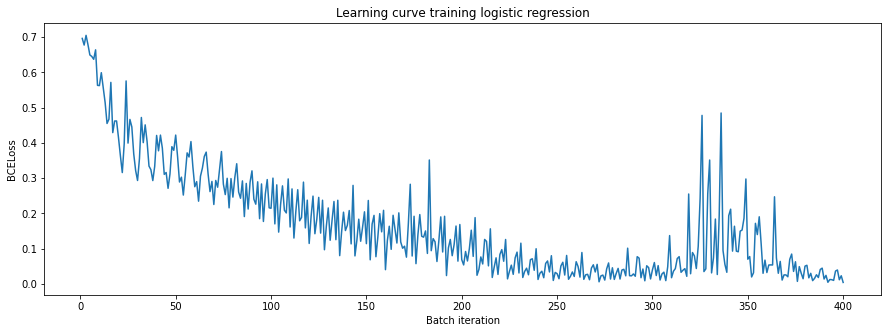

In [102]:
plt.figure(figsize=(15,5))
sns.lineplot(np.arange(1,len(losses)+1,1),losses)
plt.title("Learning curve training logistic regression")
plt.xlabel("Batch iteration")
plt.ylabel("BCELoss")

In [103]:
# Forward pass of trained network
y_pred = lr(x_test_t)
y_pred_class = y_pred.round().flatten()
acc = (y_pred_class == y_test_t).float().mean()
print("Accuracy on classification of validation set is {:.4f}".format(acc))

Accuracy on classification of validation set is 0.8525


## Conclusions

From the data it was understood that there is are indicators that lead to higher chances of having a heart attack. 

 - From the implemented models to understand the relation between the features and the probability of a person having a heart attack it is easy to implement models with at least 80% accuracy. Higher accuracy can be achieved by hyper-parameter tuning, but it is also important to consider that a type 2 error for the classifier can be very dangerous for a patient. 